In [26]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [27]:
def analyze_prototype(prototype_path, thresh_val=253, min_h=15, max_h=100):
    image = cv2.imread(prototype_path)
    if image is None:
        return None, None, None

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, thresh_val, 255, cv2.THRESH_BINARY_INV)

    h_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (40, 1))
    h_morph = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, h_kernel)
    h_lines = cv2.HoughLinesP(h_morph, 1, np.pi/180, threshold=40,
                              minLineLength=50, maxLineGap=30)

    if h_lines is None:
        return None, None, None

    y_coords = sorted(set(int(line[0][1]) for line in h_lines))
    if len(y_coords) < 2:
        return None, None, None

    row_heights = [y_coords[i+1] - y_coords[i] for i in range(len(y_coords)-1)]
    cleaned = [h for h in row_heights if min_h < h < max_h]
    if not cleaned:
        return None, None, None

    header_h = cleaned[0]
    body_heights = cleaned[1:]
    avg_row_h = np.mean(body_heights) if body_heights else header_h
    return avg_row_h, header_h, image.shape[1]

In [28]:
def find_table_cluster(y_coords, avg_row_height, tolerance=10, min_lines=3):
    if not y_coords or len(y_coords) < min_lines:
        return None

    y_coords = sorted(set(y_coords))
    best_cluster = []

    for i, start_y in enumerate(y_coords):
        cluster = [start_y]
        for y in y_coords[i+1:]:
            if abs(y - cluster[-1] - avg_row_height) <= tolerance:
                cluster.append(y)
            elif y - cluster[-1] > avg_row_height + tolerance:
                break
        if len(cluster) > len(best_cluster):
            best_cluster = cluster

    return best_cluster if len(best_cluster) >= min_lines else None

In [29]:
def extract_horizontal_lines(image, thresh_val=253):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, thresh_val, 255, cv2.THRESH_BINARY_INV)
    h_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (40, 1))
    h_morph = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, h_kernel)

    h_lines = cv2.HoughLinesP(h_morph, 1, np.pi/180, threshold=40,
                              minLineLength=50, maxLineGap=30)
    if h_lines is None:
        return []
    return [l for l in h_lines if abs(int(l[0][1]) - int(l[0][3])) < 5]

In [30]:
def detect_table_from_screenshot(screenshot_path, prototype_path):
    avg_row_proto, header_h_proto, proto_w = analyze_prototype(prototype_path)
    if avg_row_proto is None:
        print("Prototype analysis failed.")
        return

    full_img = cv2.imread(screenshot_path)
    if full_img is None:
        print("Couldnt load image.")
        return

    H_img, W_img = full_img.shape[:2]
    scale = W_img / proto_w
    avg_row_h = int(round(avg_row_proto * scale))
    header_h = int(round(header_h_proto * scale))
    tol = int(header_h * 0.3)


    # --- Extracting horizontal_lines
    h_lines = extract_horizontal_lines(full_img)
    all_y = sorted(set(int(l[0][1]) for l in h_lines))

    # Limpieza básica de alturas
    raw_h = [all_y[i+1] - all_y[i] for i in range(len(all_y)-1)]


    filtered_pairs = [(all_y[i], all_y[i+1]) for i,h in enumerate(raw_h) if h >= 15]
    cleaned_y = [filtered_pairs[0][0]] + [p[1] for p in filtered_pairs] if filtered_pairs else all_y

    # Looking for table's structure (body)
    body_coords = find_table_cluster(cleaned_y, avg_row_h, tolerance=tol)
    if not body_coords:
        print("No table found.")
        return

    print("\nBody's table found")
    final_coords = [int(y) for y in body_coords]

    # Header detection
    top_body = min(final_coords)
    exp_header_y = top_body - header_h
    candidates = [y for y in cleaned_y if y < top_body]
    if candidates:
        best_header = min(candidates, key=lambda y: abs(y - exp_header_y))
        if abs(best_header - exp_header_y) <= tol * 1.5:
            print(f"Header in Y={best_header}")
            final_coords.insert(0, best_header)

    # Y Limits
    table_top, table_bottom = min(final_coords), max(final_coords)

    # X min/max → percentiles
    lefts = np.array([min(l[0][0], l[0][2]) for l in h_lines if int(l[0][1]) in final_coords])
    rights = np.array([max(l[0][0], l[0][2]) for l in h_lines if int(l[0][1]) in final_coords])

    if len(lefts) and len(rights):
        table_left = int(np.percentile(lefts, 10))
        table_right = int(np.percentile(rights, 90))
    else:
        table_left, table_right = 0, W_img - 1

    # Clamp
    table_left = max(0, min(W_img-1, table_left))
    table_right = max(0, min(W_img-1, table_right))

    debug = full_img.copy()

    # Body rows (yellow)
    for i in range(1, len(final_coords)-1):
        y1, y2 = final_coords[i], final_coords[i+1]
        if y2 > y1 + 1:
            cv2.rectangle(debug, (table_left, y1), (table_right, y2), (0,255,255), 2)

    # Header (green)
    if len(final_coords) >= 2:
        cv2.rectangle(debug, (table_left, final_coords[0]), (table_right, final_coords[1]), (0,200,0), 3)

    # Table (red)
    cv2.rectangle(debug, (table_left, table_top), (table_right, table_bottom), (0,0,255), 4)

    plt.figure(figsize=(15,10))
    plt.imshow(cv2.cvtColor(debug, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()


Body's table found
Header in Y=399


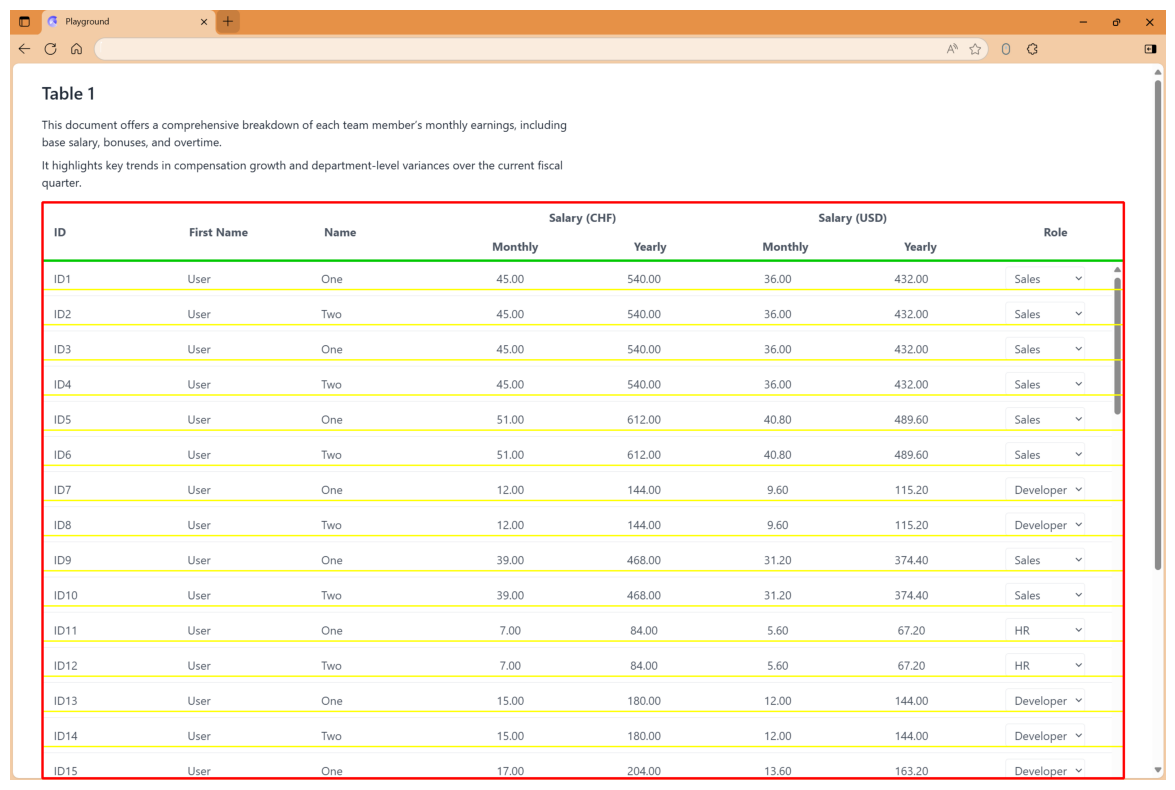

In [31]:
detect_table_from_screenshot('WEB.png', 'WEB-2.png')